In [1]:
import numpy as np
import scanpy as sc
import torch

import matplotlib.pyplot as plt
from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE, TRANVAE
from sklearn.metrics import classification_report

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
unlabeled_strat = "batch"
cells_per_ct = 2000

# Model Params
latent_dim = 10
use_mmd = False

# Training Params
alpha_epoch_anneal = 1e6
eta = 1
tau = 0
clustering_res = 2
labeled_loss_metric = "dist"
unlabeled_loss_metric = "dist"
class_metric = "dist"

early_stopping_kwargs = {
    "early_stopping_metric": "val_classifier_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

cell_type_key = ["cell_type"]

In [3]:
DATA_DIR = '../../lataq_reproduce/data'
adata = sc.read(
    f'{DATA_DIR}/pancreas.h5ad'
)
condition_key = 'study'
reference = ["inDrop1", "inDrop2", "inDrop3", "inDrop4", "fluidigmc1", "smartseq2", "smarter"]
query = ["celseq", "celseq2"]

In [4]:
adata = remove_sparsity(adata)
source_adata = adata[adata.obs[condition_key].isin(reference)]
target_adata = adata[adata.obs[condition_key].isin(query)]
indices = np.arange(len(adata))
#stratified label/unlabeled split
if unlabeled_strat == "batch":
    labeled_ind = indices[adata.obs.study.isin(reference)].tolist()
    labeled_adata = adata[adata.obs.study.isin(reference)].copy()
    unlabeled_adata = adata[adata.obs.study.isin(query)].copy()
if unlabeled_strat == "ct":
    labeled_ind = []
    cts = adata.obs[cell_type_key[0]].unique().tolist()
    for celltype in cts:
        ct_indices = indices[adata.obs[cell_type_key[0]].isin([celltype])]
        ct_sel_ind = np.random.choice(ct_indices, size=cells_per_ct, replace=False)
        labeled_ind += ct_sel_ind.tolist()
        print(celltype, len(ct_indices), len(ct_sel_ind), len(labeled_ind))
    unlabeled_ind = np.delete(indices, labeled_ind).tolist()
    labeled_adata = adata[labeled_ind].copy()
    unlabeled_adata = adata[unlabeled_ind].copy()

In [5]:
embed = EMBEDCVAE(
    adata=source_adata,
    condition_key=condition_key,
    inject_condition = ['decoder'],
    embedding_dim = 10,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128, 128],
    latent_dim=latent_dim,
    use_mmd=use_mmd,
    labeled_indices=labeled_ind,
    unknown_ct_names=None
)

Embedding dictionary:
 	Num conditions: 7
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 



In [6]:
embed.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=400,
    alpha_epoch_anneal=alpha_epoch_anneal,
    eta=100,
    tau=tau,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

Trying to set attribute `.obs` of view, copying.


 |████████████████████| 100.0%  - val_loss: 1024.6940030185 - val_trvae_loss: 1013.6491921165 - val_classifier_loss: 11.0448165373 - val_labeled_loss: 0.1104481661
Saving best state of network...
Best State was in Epoch 499


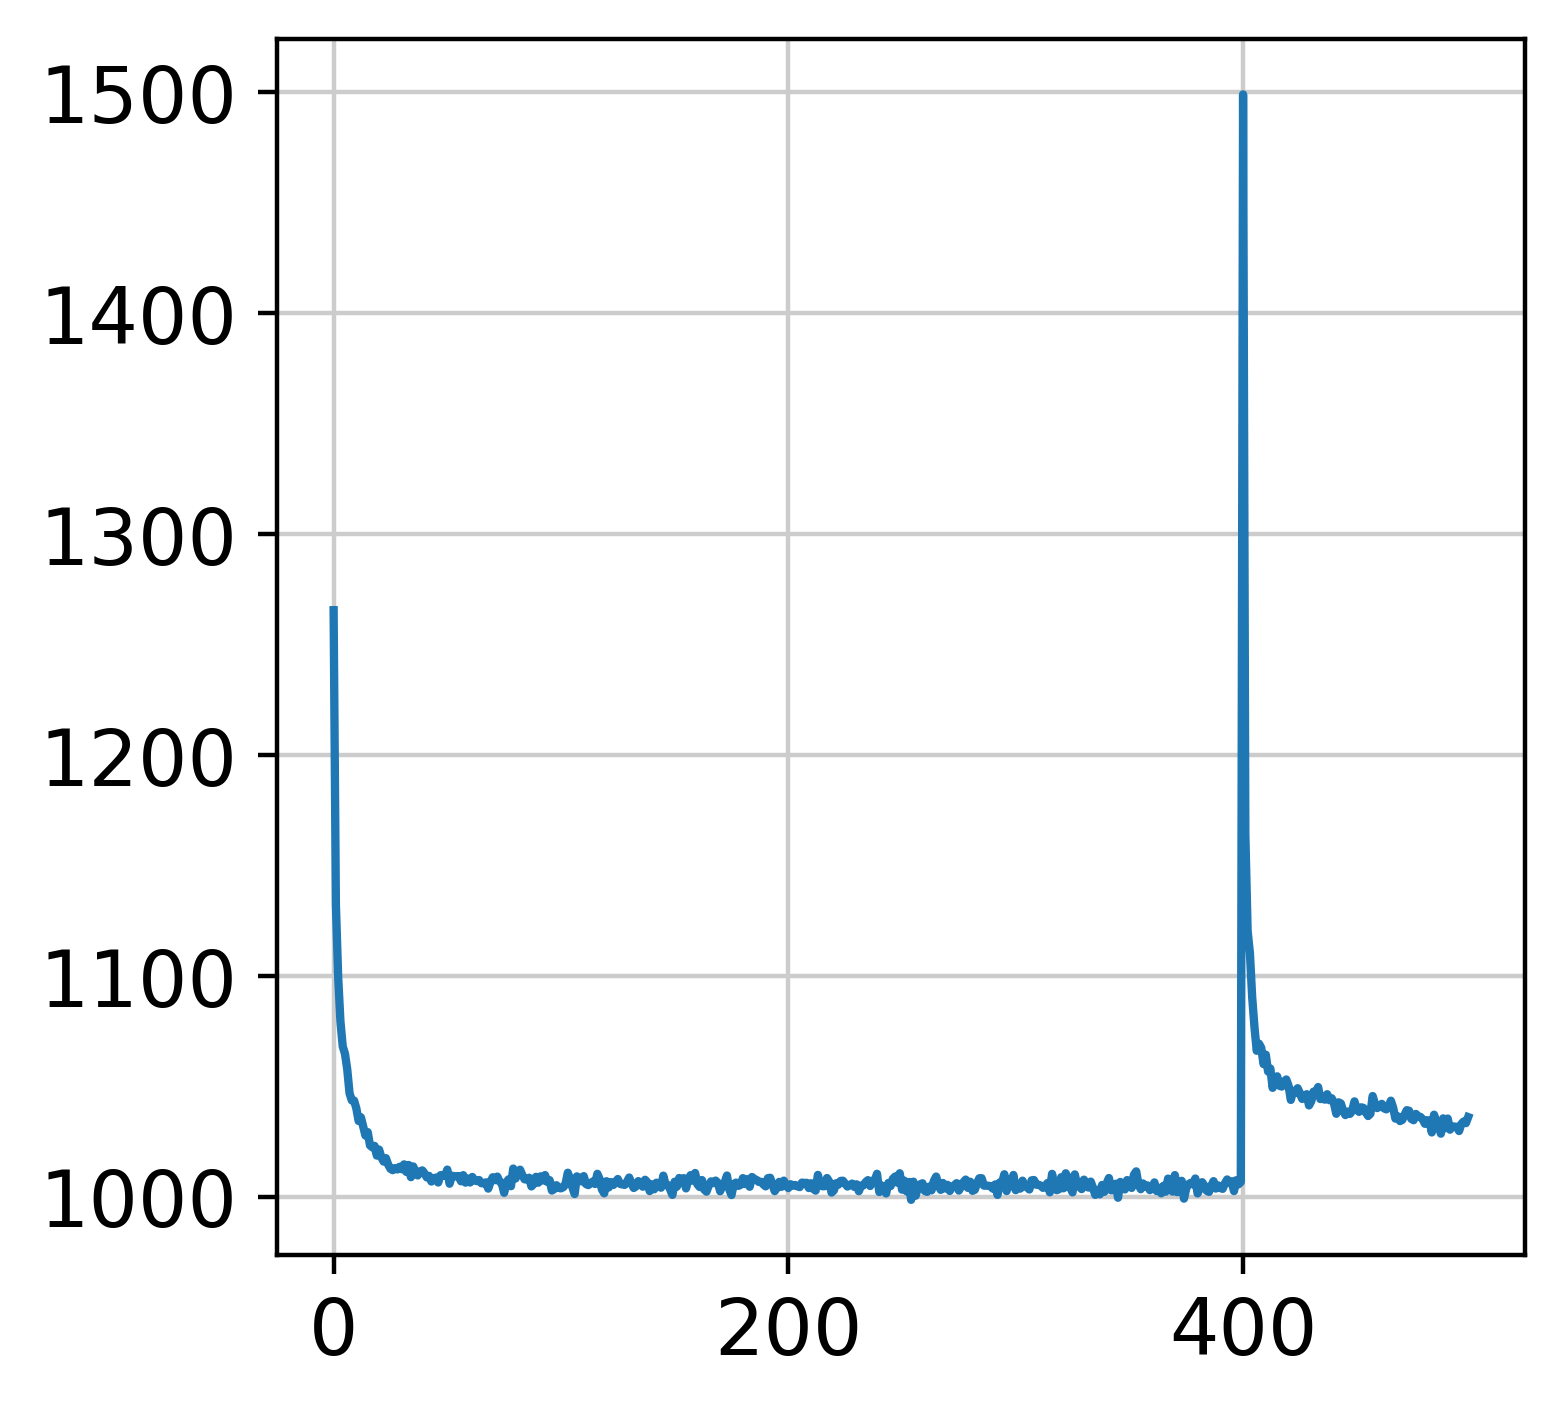

In [7]:
plt.plot(embed.trainer.logs['epoch_loss'])

{'cell_type': {'preds': array(['gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', ...,
       'epsilon', 'quiescent_stellate', 'quiescent_stellate',
       'quiescent_stellate', 'quiescent_stellate', 'quiescent_stellate',
       'quiescent_stellate'], dtype='<U18'), 'probs': array([0.3 , 0.31, 0.31, 0.29, 0.31, 0.3 , 0.3 , ..., 0.28, 0.39, 0.39,
       0.39, 0.4 , 0.39, 0.4 ], dtype=float32)}}


... storing 'batch' as categorical


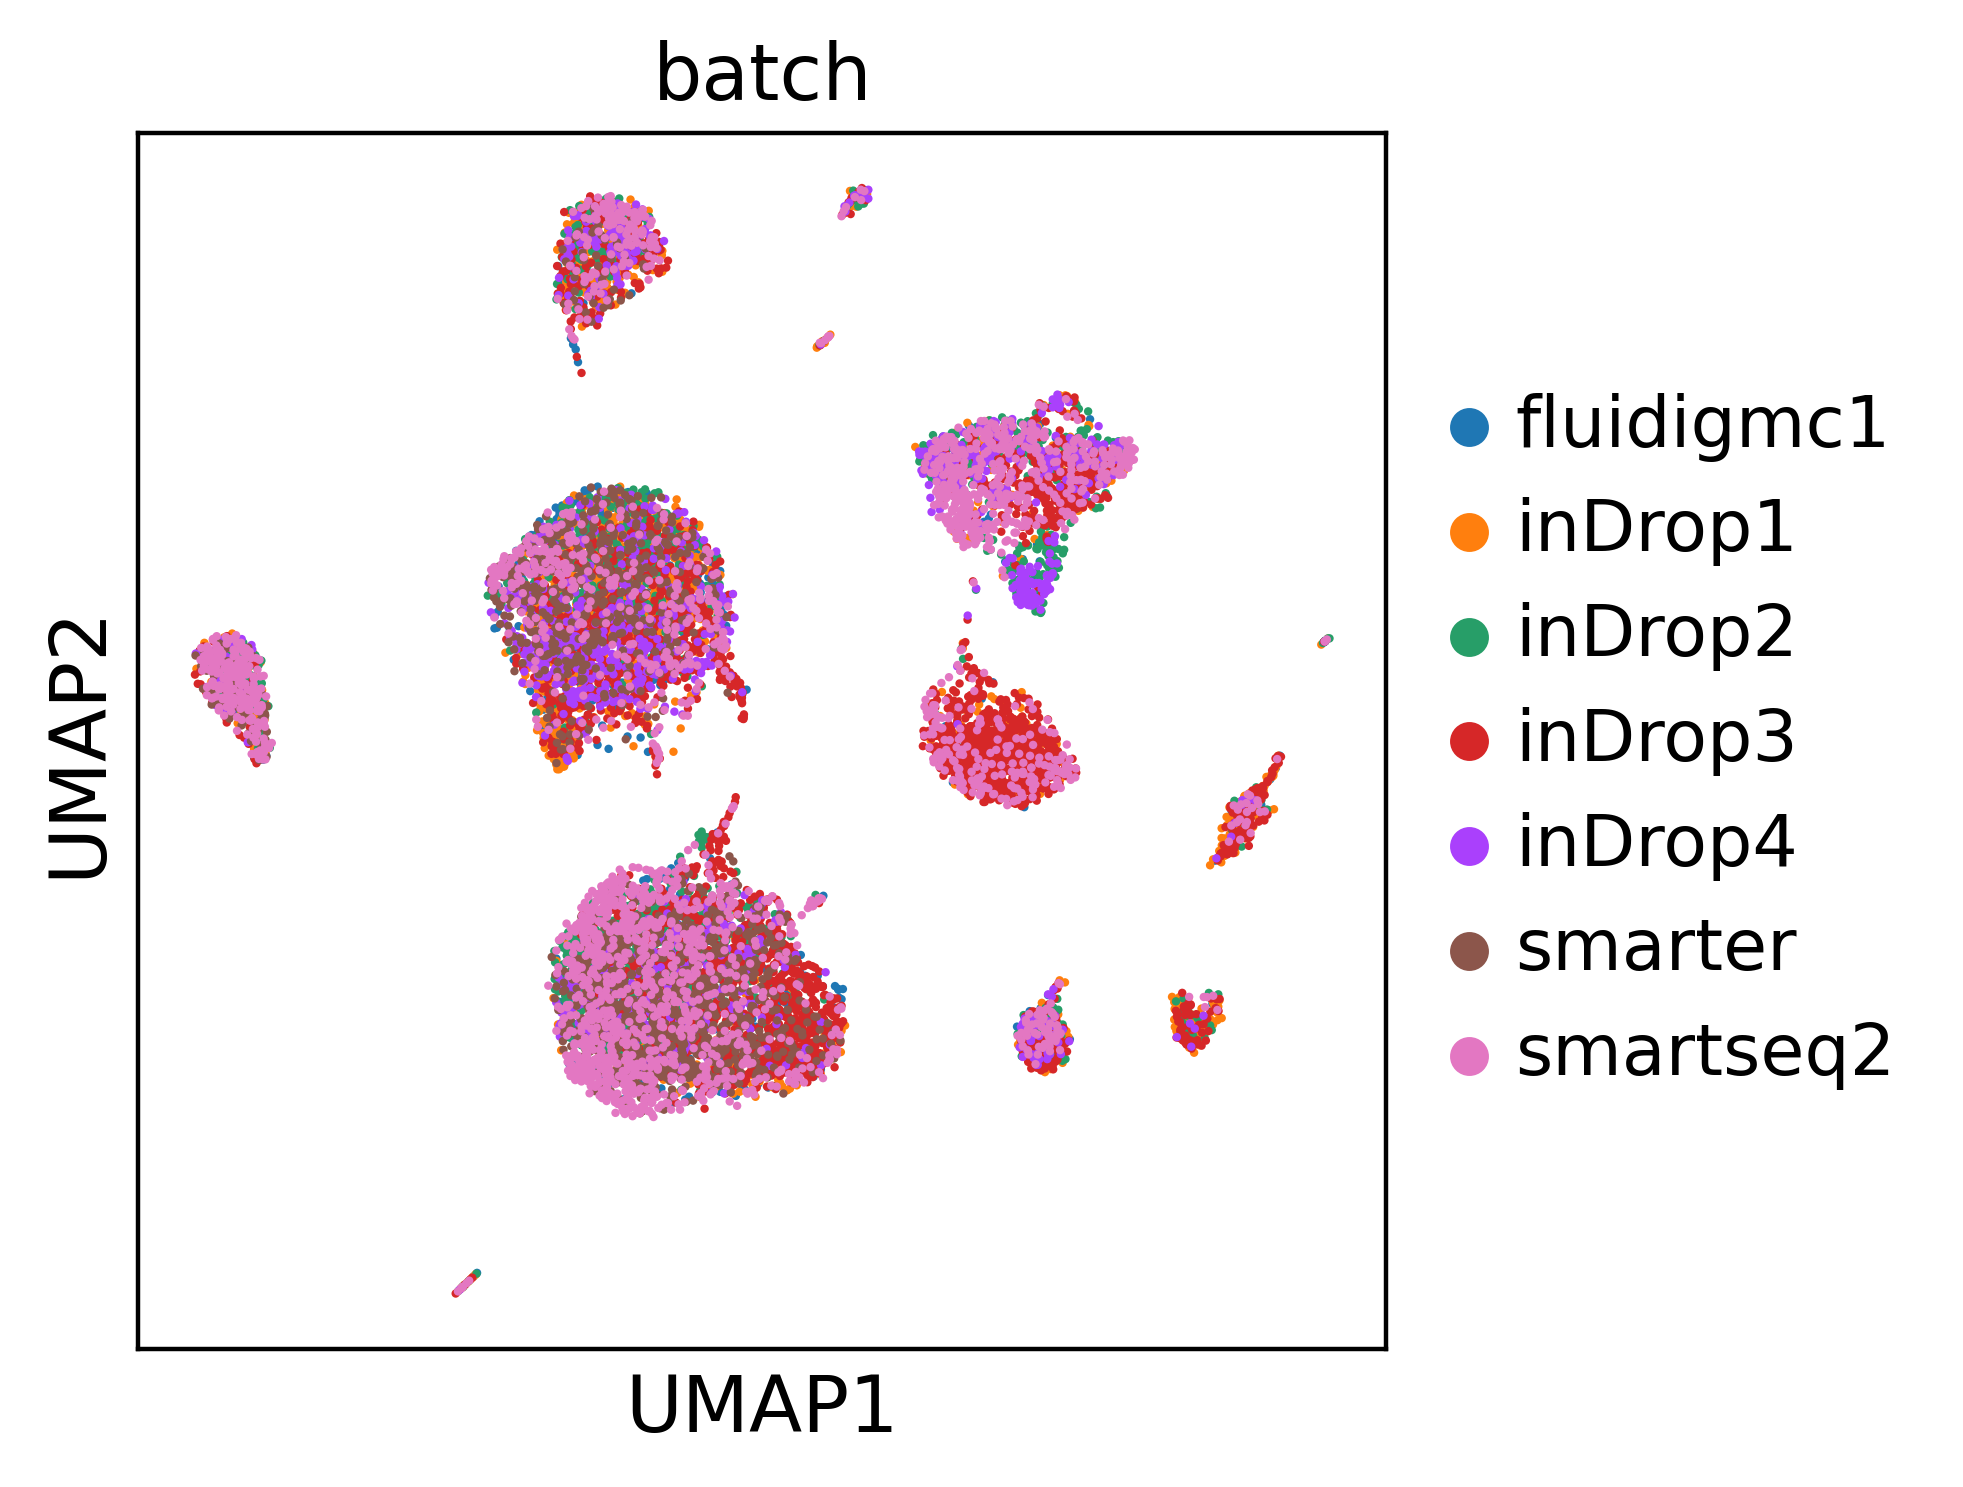

In [8]:
data_latent = embed.get_latent(
    labeled_adata.X, 
    labeled_adata.obs[condition_key].values
)
adata_latent_embed_dec = sc.AnnData(data_latent)
adata_latent_embed_dec.obs['batch'] = labeled_adata.obs[condition_key].tolist()
results_dict_embed_dec = embed.classify(
    labeled_adata.X, 
    labeled_adata.obs[condition_key], 
    metric=class_metric
)
print(results_dict_embed_dec)
sc.pp.neighbors(adata_latent_embed_dec)
sc.tl.umap(adata_latent_embed_dec)
sc.pl.umap(adata_latent_embed_dec, color='batch')

In [9]:
embedding = embed.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)

IndexError: index 7 is out of bounds for axis 0 with size 7

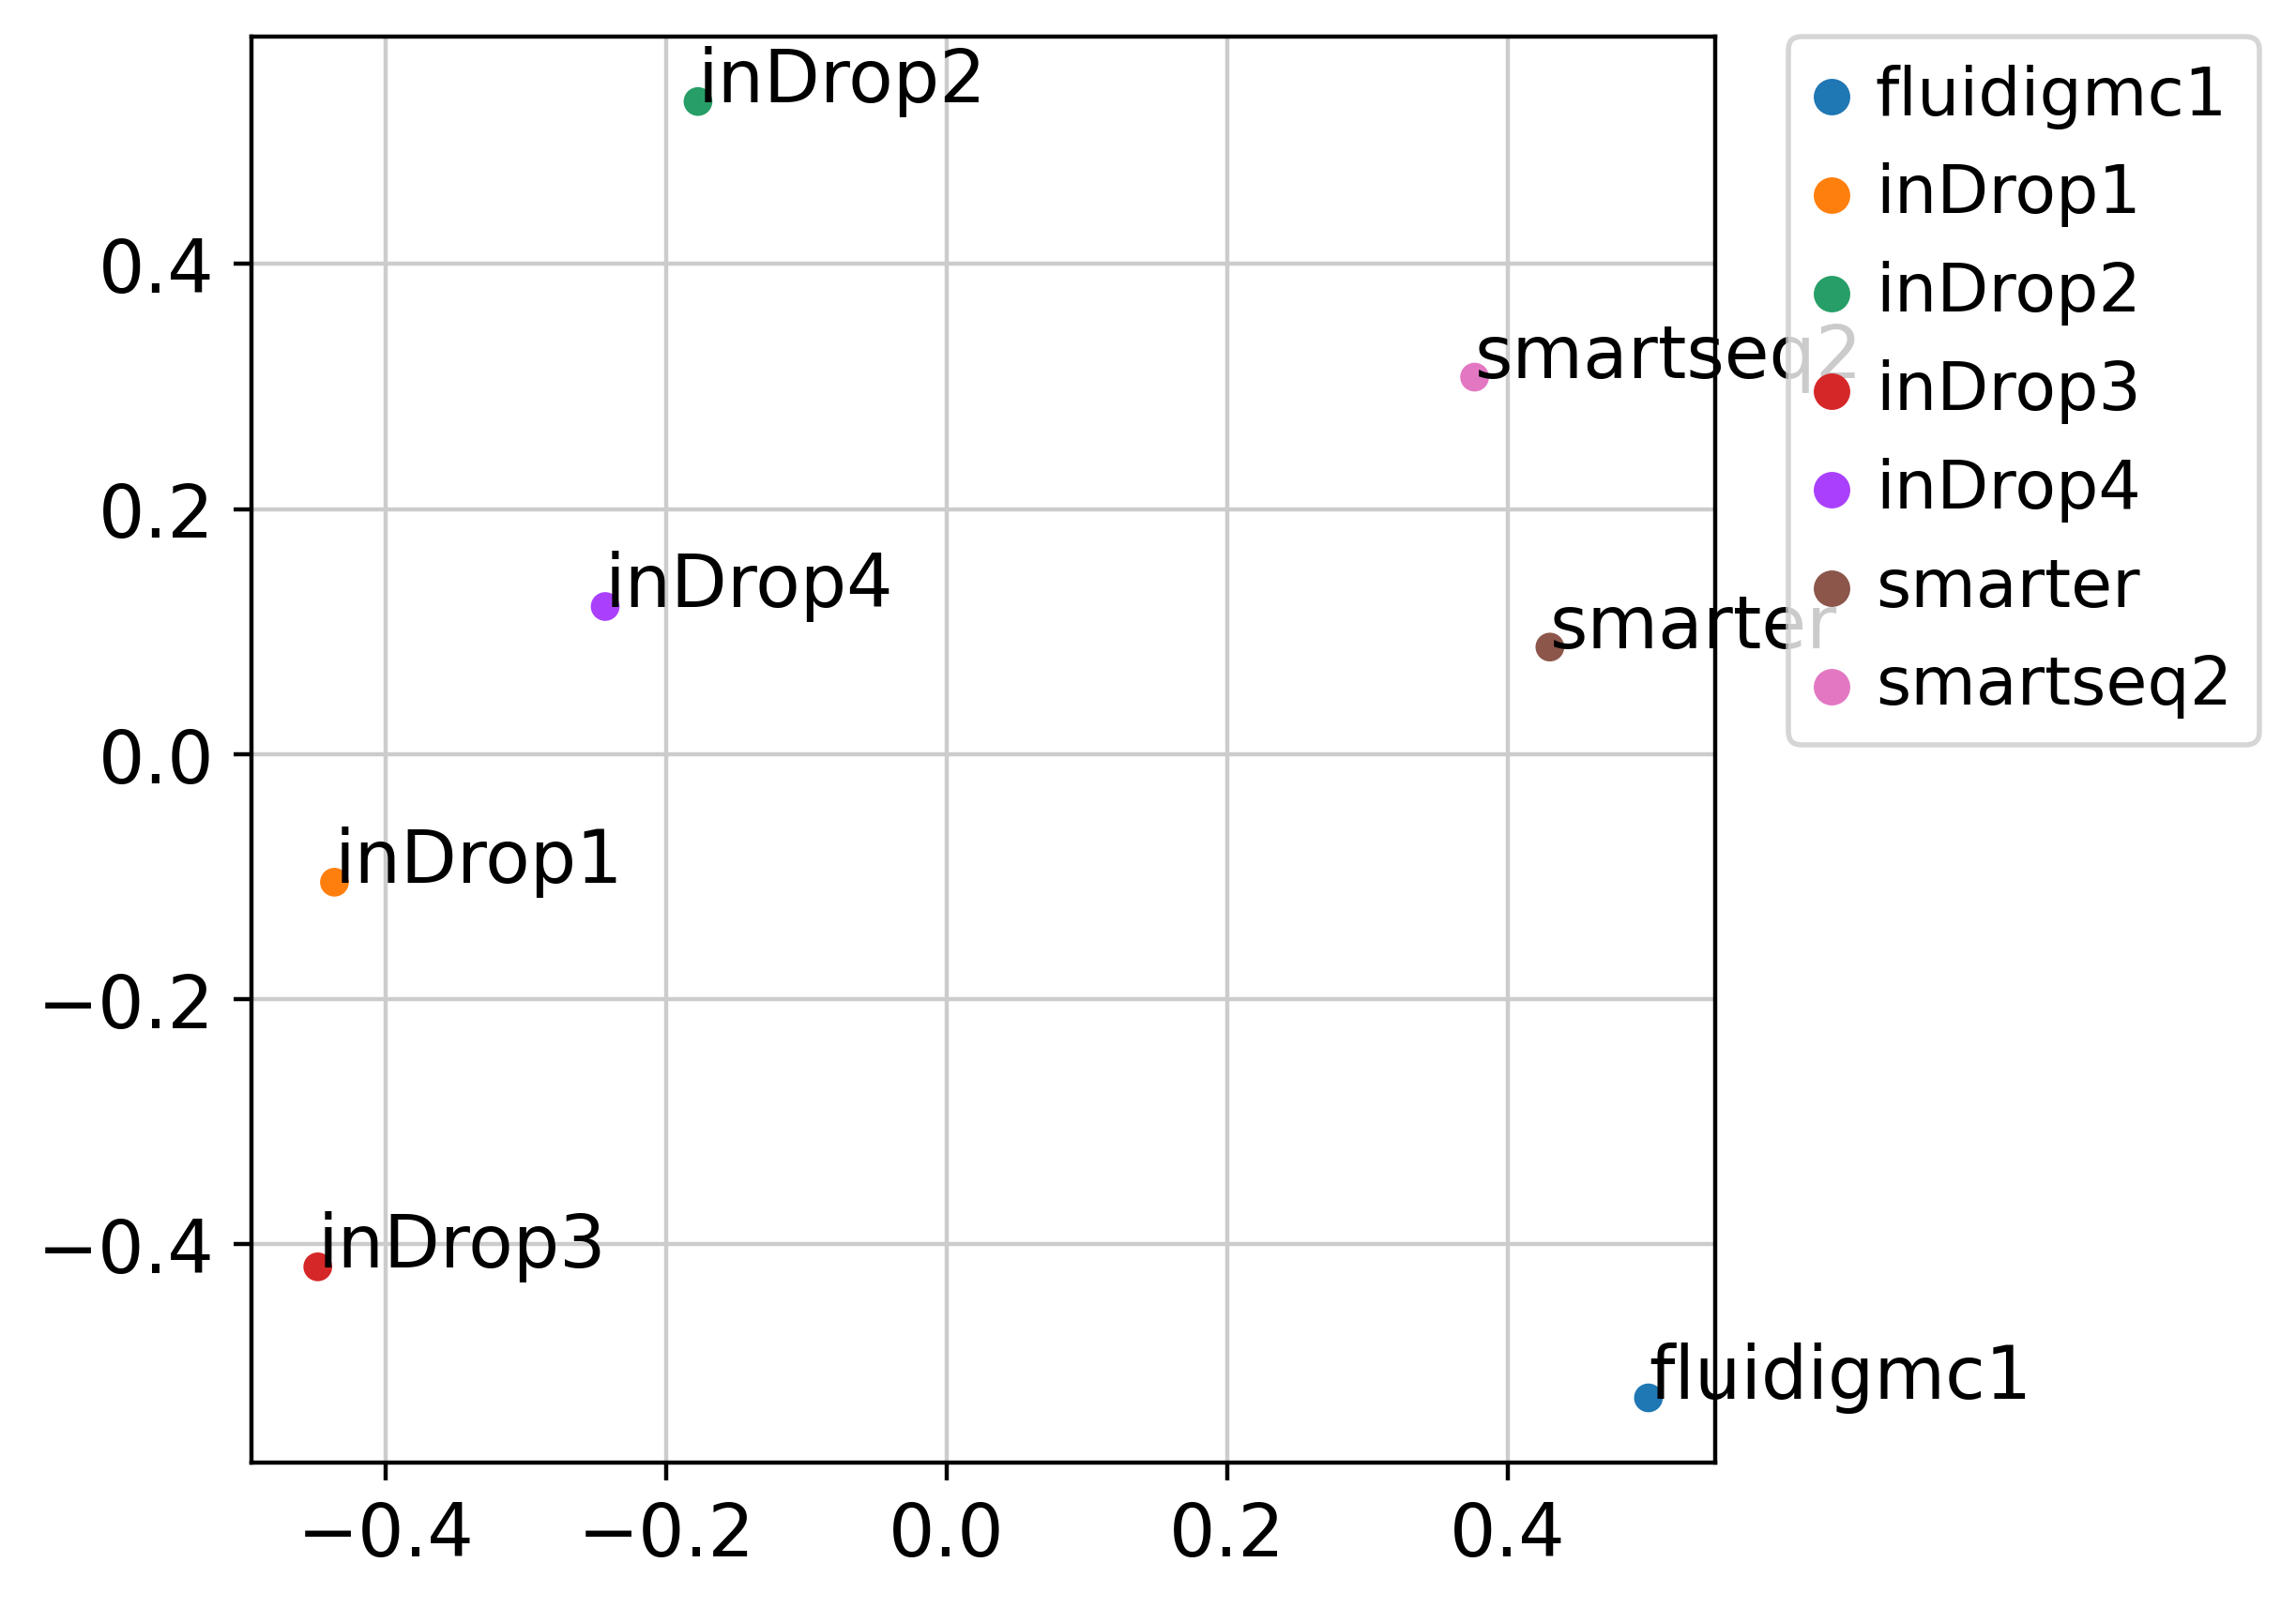

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], source_adata.obs[condition_key].unique(), ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(adata.obs[condition_key].unique()):
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

In [12]:
embed.save('tmp', overwrite=True)

In [14]:
embed_query = EMBEDCVAE.load_query_data(
    adata=target_adata,
    reference_model=f'tmp',
    labeled_indices=[],
)
embed_query.train(
    n_epochs=500,
    early_stopping_kwargs=early_stopping_kwargs,
    pretraining_epochs=100,
    eta=eta,
    tau=tau,
    weight_decay=0,
    clustering_res=clustering_res,
    labeled_loss_metric=labeled_loss_metric,
    unlabeled_loss_metric=unlabeled_loss_metric
)

Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type'
    obsm: 'X_seurat', 'X_symphony'
Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 4000 

 |████----------------| 20.0%  - val_loss: 2414.0020345052 - val_trvae_loss: 2414.0020345052
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 22 clusters.
 |█████---------------| 28.4%  - val_loss: 2399.7342936198 - val_trvae_loss: 2399.7334798177 - val_classifier_loss: 0.0008708499 - val_unlabeled_loss: 0.8708498677
ADJUSTED LR
 |█████---------------| 29.8%  - val_loss: 2397.9271647135 - val_trvae_loss: 2397.9263509115 - val_classifier_loss: 0.0008360155 - val_unlabeled_loss: 0.83601

In [15]:
embedding = embed_query.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='cosine')
emb_pca = pca.fit_transform(embedding)

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


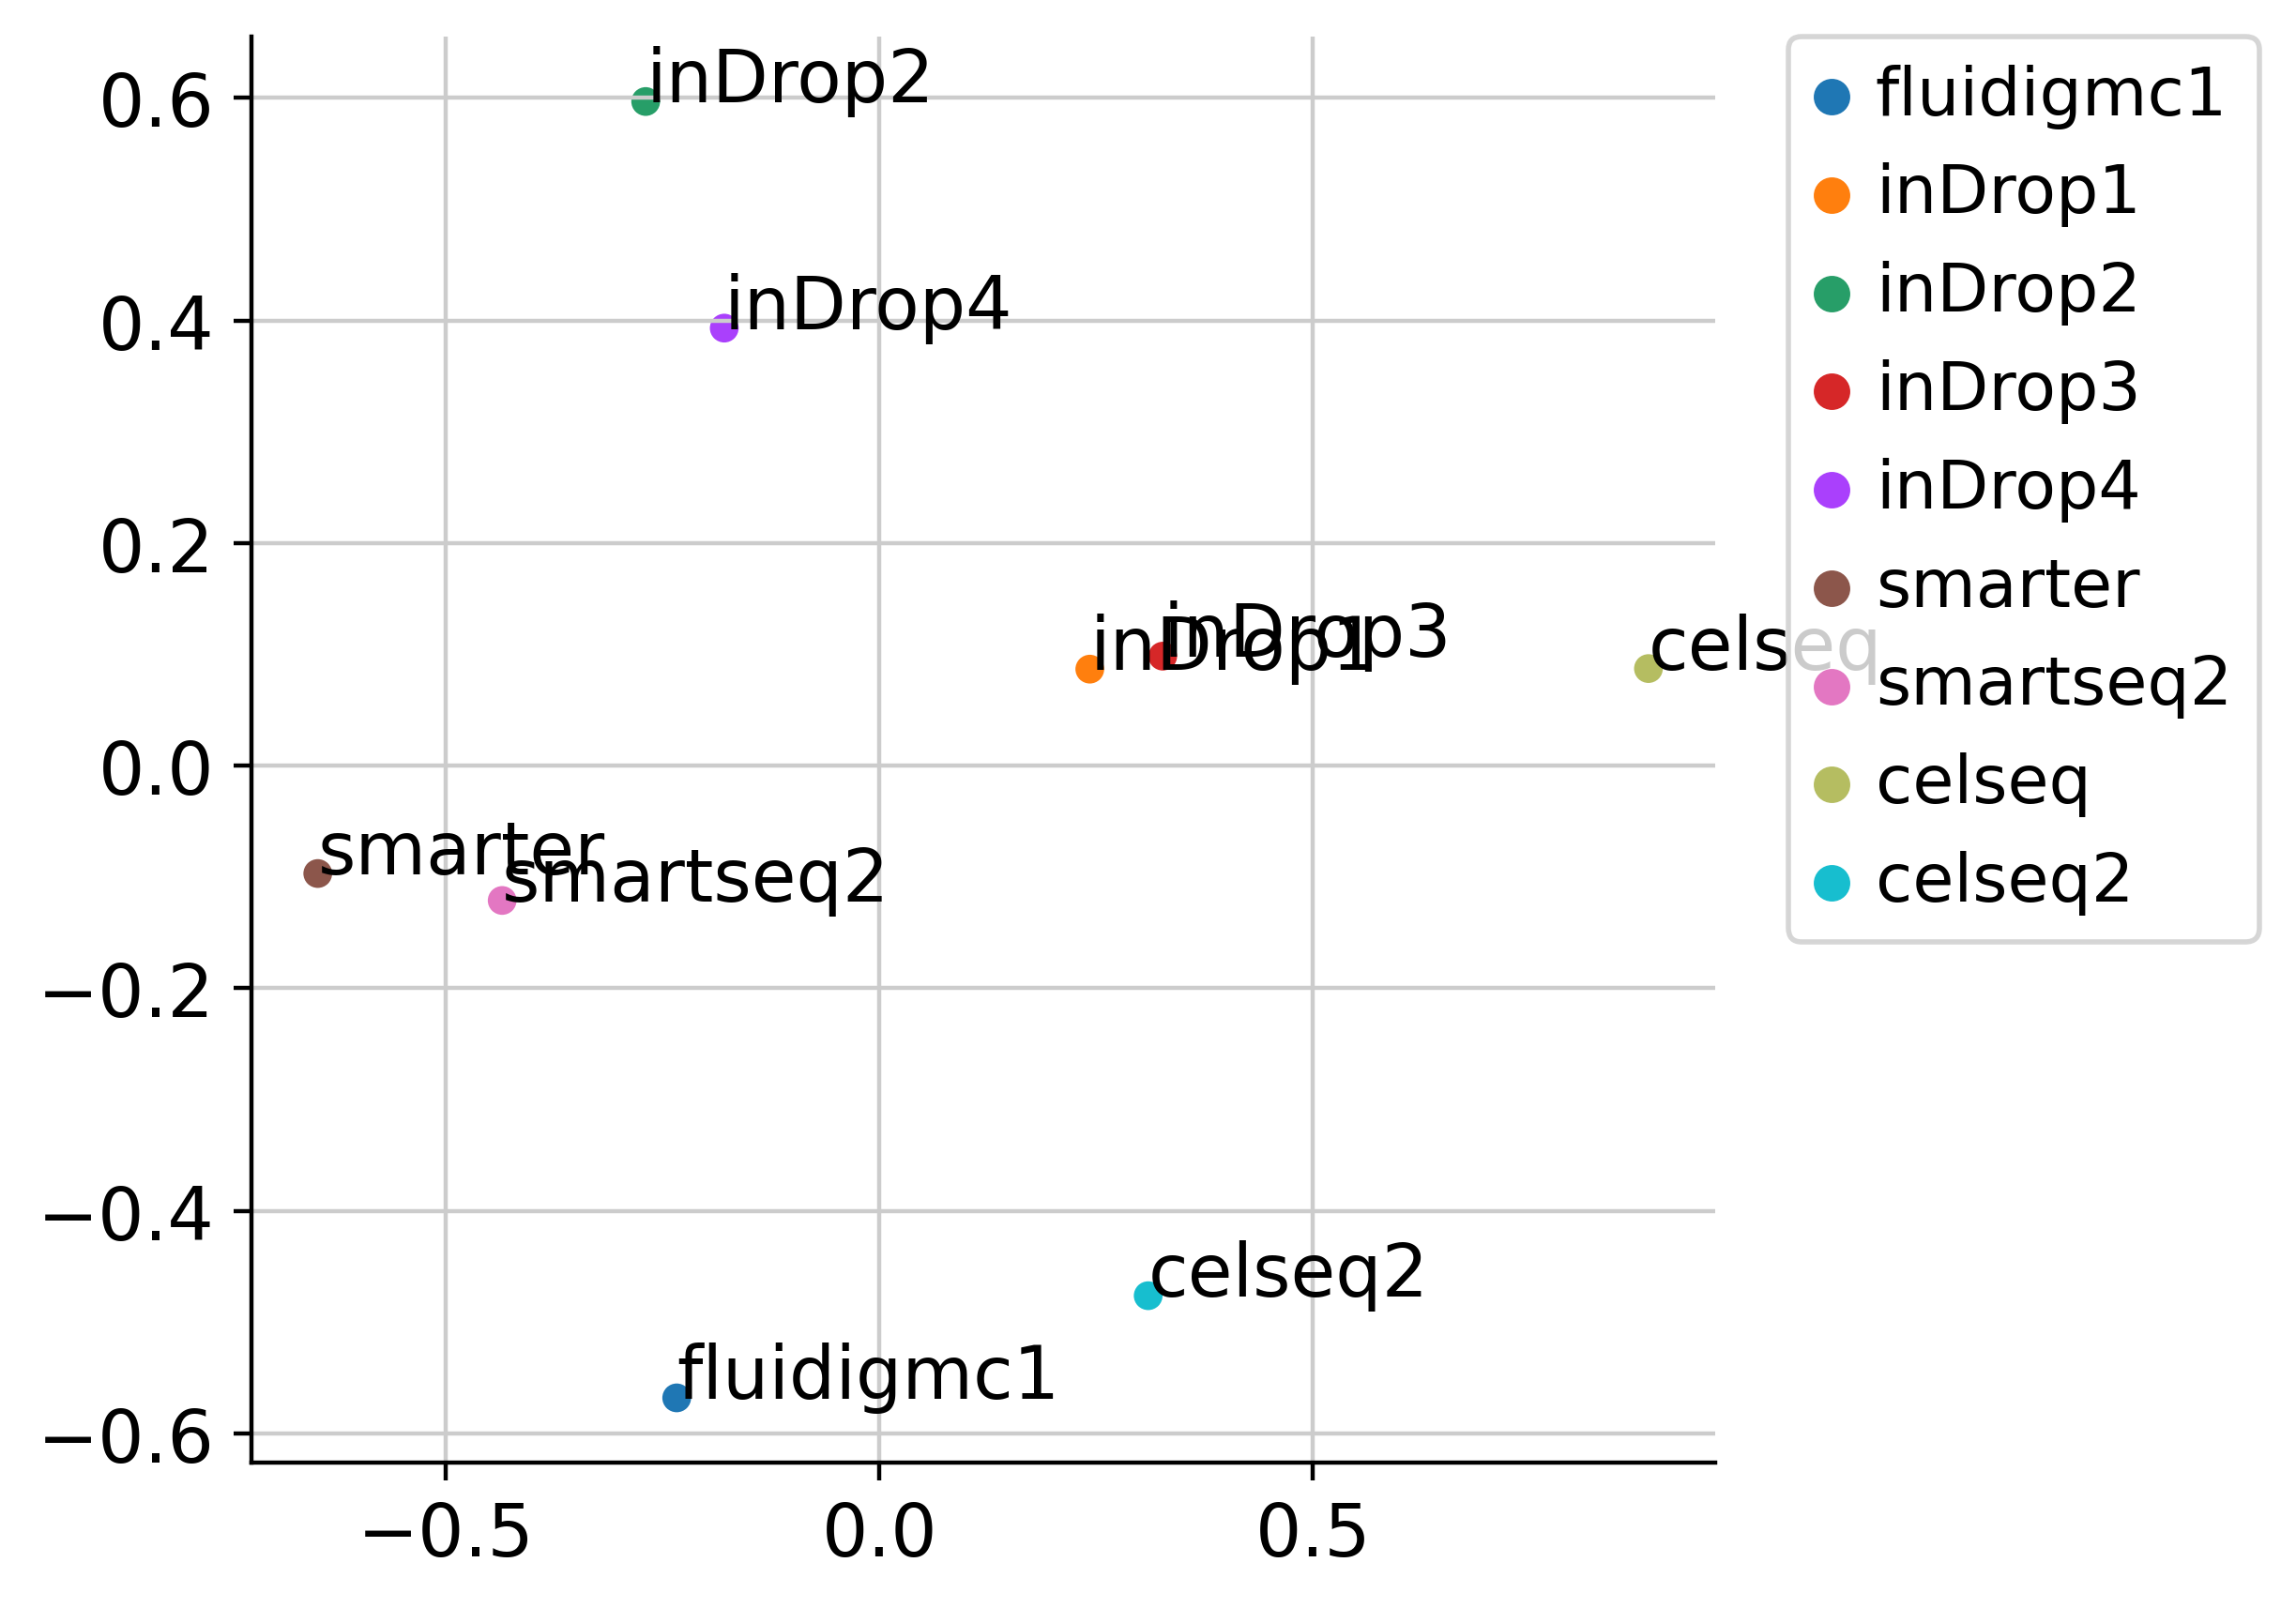

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], adata.obs[condition_key].unique(), ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(adata.obs[condition_key].unique()):
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

In [14]:
for i in range(len(cell_type_key)):
    preds = results_dict[i]['preds']
    probs = results_dict[i]['probs']

    rep = classification_report(
            y_true=labeled_adata.obs[cell_type_key[i]],
            y_pred=preds,
            labels=np.array(labeled_adata.obs[cell_type_key[i]].unique().tolist())
        )
    correct_probs = probs[preds == labeled_adata.obs[cell_type_key[i]]]
    incorrect_probs = probs[preds != labeled_adata.obs[cell_type_key[i]]]
    data = [correct_probs, incorrect_probs]
            
    #correct, incorrect prob plot
    fig, ax = plt.subplots()
    ax.set_title('Default violin plot')
    ax.set_ylabel('Observed values')
    ax.violinplot(data)
    labels = ['Correct', 'Incorrect']

    checks = np.array(len(labeled_adata) * ['incorrect'])
    checks[preds == labeled_adata.obs[cell_type_key[i]]] = 'correct'
    adata_latent.obs[cell_type_key[i]] = labeled_adata.obs[cell_type_key[i]].tolist()
    adata_latent.obs[f'{cell_type_key[i]}_pred'] = preds.tolist()
    adata_latent.obs[f'{cell_type_key[i]}_bool'] = checks.tolist()

NameError: name 'results_dict' is not defined

In [ ]:
for i in range(len(cell_type_key)):
    preds = results_dict_embed[i]['preds']
    probs = results_dict_embed[i]['probs']

    rep = classification_report(
            y_true=labeled_adata.obs[cell_type_key[i]],
            y_pred=preds,
            labels=np.array(labeled_adata.obs[cell_type_key[i]].unique().tolist())
        )
    correct_probs = probs[preds == labeled_adata.obs[cell_type_key[i]]]
    incorrect_probs = probs[preds != labeled_adata.obs[cell_type_key[i]]]
    data = [correct_probs, incorrect_probs]
            
    #correct, incorrect prob plot
    fig, ax = plt.subplots()
    ax.set_title('Default violin plot')
    ax.set_ylabel('Observed values')
    ax.violinplot(data)
    labels = ['Correct', 'Incorrect']

    checks = np.array(len(labeled_adata) * ['incorrect'])
    checks[preds == labeled_adata.obs[cell_type_key[i]]] = 'correct'
    adata_latent.obs[cell_type_key[i]] = labeled_adata.obs[cell_type_key[i]].tolist()
    adata_latent.obs[f'{cell_type_key[i]}_pred'] = preds.tolist()
    adata_latent.obs[f'{cell_type_key[i]}_bool'] = checks.tolist()